In [1]:
%%HTML
<style>
div.prompt {display:none}
</style>
// hide input prompt
$(document).ready(function() {
    $('div.prompt').css('display', 'none');
});

### 회귀 트리
- 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측
- 리프 노드에서 예측 결정 값을 만드는 과정에서 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산
- 결정트리, 랜덤 포레스트, GBM, XGBOOST, LIGHTGBM 등 트리 기반의 알고리즘은 분류뿐만 아니라 회귀도 가능한데 트리 생성이 CART(Classification And Regression Trees)에 기반하고 있기 때문이며 CART는 분류뿐만 아니라 회귀도 가능하게 해주는 트리 생성 알고리즘임

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['PRICE']=boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [28]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [29]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [31]:
# 종속변후 PRICE를 y_target변수에 할당. 
y_target = boston_df.PRICE

# 'PRICE' 열을 제외한 나머지 열을 포함하는 DataFrame을 X_data 변수에 할당
X_data = boston_df.drop(['PRICE'],axis=1)

#random_state는 재현 가능성을 위한 난수 시드 값이고, 
#n_estimators는 생성할 트리의 개수
rf = RandomForestRegressor(random_state=0, n_estimators =1000)


# cross_val_score 함수를 사용하여 교차 검증을 수행
# RandomForestRegressor 모델을 사용하여 X_data와 y_target를 입력
# scoring은 평가 지표로 평균 제곱 오차의 음수값인 neg_mean_squared_error를 사용
#  cv는 5-fold 교차 검증을 수행
neg_mse_scores = cross_val_score(rf, X_data, y_target,\
                                 scoring = 'neg_mean_squared_error',cv=5)
# =교차 검증의 각 폴드에서 모델의 예측값과 실제값 간의 평균 제곱 오차를 계산하고, 그 결과를 음수로 반환

#neg_mse_scores를 양수로 변환하여 평균 제곱근 오차(RMSE) 값을 계산
#(평균 제곱 오차의 음수값을 양수로 변환한 뒤 제곱근을 취한 것)
rmse_scores = np.sqrt(-1*neg_mse_scores)

#각 교차 검증의 RMSE 값을 평균하여 평균 RMSE 값을 계산
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE: ', np.round(neg_mse_scores,2))
print(' 5 교차 검증의 개별 RMSE: ', np.round(rmse_scores,2))
print(' 5 교차 검증의 평균 RMSE: ', np.round(avg_rmse ,2))

 5 교차 검증의 개별 Negative MSE:  [ -7.89 -13.06 -20.62 -46.14 -18.81]
 5 교차 검증의 개별 RMSE:  [2.81 3.61 4.54 6.79 4.34]
 5 교차 검증의 평균 RMSE:  4.42


In [32]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target,\
                                    scoring = 'neg_mean_squared_error',cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    #현재 모델 객체가 속한 클래스 이름을 출력합니다. 
    #이는 모델의 타입을 확인하는 용도로 사용    
    print('#####',model.__class__.__name__, '#####') 
    
    # 각 객체들이 속한 클래스 이름을 프린트함
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))
    
    
    
#이 함수를 호출하면 입력된 모델과 데이터에 대해 교차 검증이 수행되고, 
#평균 RMSE 값이 출력됩니다. 이를 통해 모델의 예측 성능을 평가할 수 있다

In [33]:
# pip install xgboost

In [34]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DTR(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GBR(random_state=0, n_estimators = 1000 )
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

#트리기반의 회귀 모델을 반복하여 평가 수행

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE : 5.883
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE : 4.419
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE : 4.259
##### XGBRegressor #####
5 교차 검증의 평균 RMSE : 4.251
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE : 4.646


<Axes: >

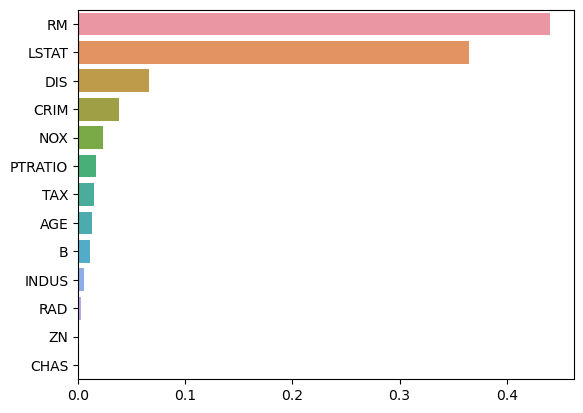

In [35]:
import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators = 1000)
rf_reg.fit(X_data, y_target)
feature_series = pd.Series(data =rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y= feature_series.index)

(100, 2)


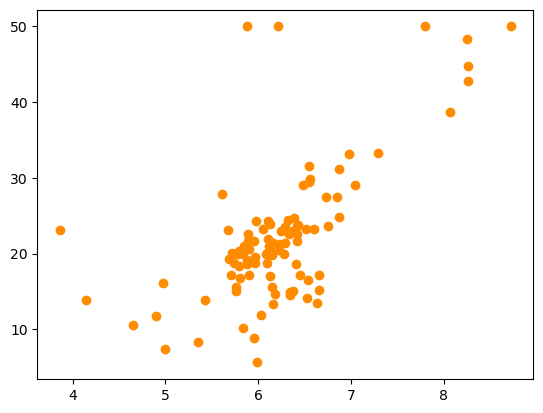

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = boston_df[['RM','PRICE']]
bostonDF_sample= bostonDF_sample.sample(n = 100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()
rf_reg2 = DTR(max_depth=2)
rf_reg7 = DTR(max_depth=7)

X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target= bostonDF_sample['PRICE'].values.reshape(-1,1)

lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)


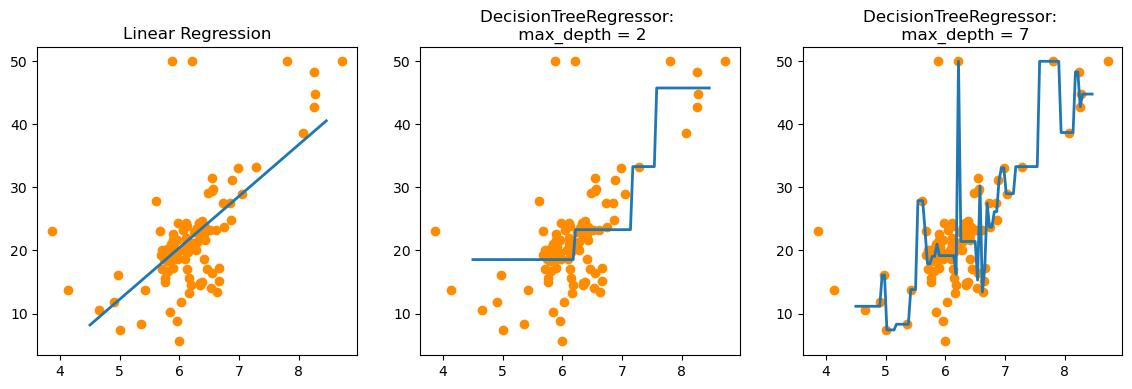

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize =(14,4), ncols=3)

# x축 값을 4.5~8.5로 반환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선

ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label="linear",linewidth=2)

#DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('DecisionTreeRegressor: \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label="max_depth : 2",linewidth=2)

#DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('DecisionTreeRegressor: \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label="max_depth : 7",linewidth=2)